# Fully Connected NN (Question 1a)

In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms


In [2]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
# print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Is CUDA supported by this system? True
CUDA version: 11.7
ID of current CUDA device: 0


In [3]:
save_path = 'models/'
sub_name = '_cuda'

batch_size = 1000

# Import Data

In [4]:
from torchvision import datasets
data_path = '../dataset/cifar10'
cifar10     = datasets.CIFAR10(data_path, train=True , download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
cifar10_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
sample_image = 70

## verify data

5 : dog
  <PIL.Image.Image image mode=RGB size=32x32 at 0x23EF9DD0250>


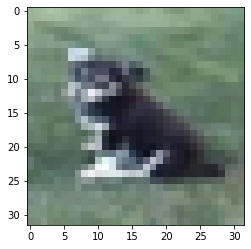

In [6]:
img, label = cifar10[sample_image]
print(f'{label} : {cifar10_map[label]}\n  {img}')
plt.imshow(img)
plt.show()

In [7]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

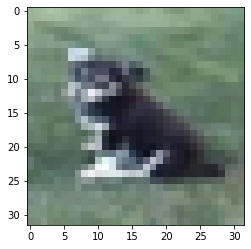

In [8]:
plt.imshow(img_t.permute(1, 2, 0))  # <1>
plt.show()

# get std deviation and mean

In [9]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())

In [10]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [11]:
data_mean = imgs.view(3, -1).mean(dim=1)
data_std  = imgs.view(3, -1).std(dim=1)

print(f'mean = {data_mean}')
print(f'std = {data_std}')

mean = tensor([0.4914, 0.4822, 0.4465])
std = tensor([0.2470, 0.2435, 0.2616])


In [12]:
transforms.Normalize(data_mean, data_std)

Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))

# Better import  

In [13]:
# to save memory
del cifar10, cifar10_val, tensor_cifar10, imgs
try:
    cifar10[0]
    print("not deleted")
except:
    print("deleted")

deleted


In [14]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, # mean of entire dataset
                             data_std) # std deviation of entire dataset
    ]))

In [15]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)
    ]))

## verify data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


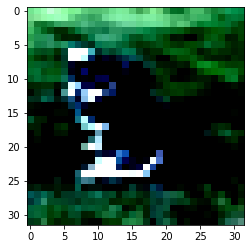

torch.Size([3, 32, 32])


3072

In [16]:
img, label = cifar10[sample_image]

plt.imshow(img.permute(1, 2, 0))
plt.show()

print(img.shape)
torch.numel(img)

# 1 layer NN
part a

## Setup

In [17]:
import torch.nn as nn
from collections import OrderedDict


n_in = torch.numel(img)  # Number of elements in 3 x 32 x 32 image
                         # IE.  3072
n_out = len(cifar10_map) # number of possible outputs
                         # IE.  10
n_inner = 512 


model1 = nn.Sequential(OrderedDict([
        ("hidden_layer",
        nn.Linear(
            n_in,
            512,   
        )),
        ("hidden_activation",
        nn.Tanh()
        ),
        ("output",
        nn.Linear(
            512,   
            n_out, 
        )),
        ("softmax",
        nn.LogSoftmax(dim=1)
        ),
    ]))
model = model1.to(device)
model

Sequential(
  (hidden_layer): Linear(in_features=3072, out_features=512, bias=True)
  (hidden_activation): Tanh()
  (output): Linear(in_features=512, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [18]:
loss = nn.NLLLoss()
loss = loss.to(device)

## setup test

In [19]:
img, label = cifar10[sample_image]
label = torch.tensor([label])

# CUDA support
img = img.to(device)
label = label.to(device)

out = model(img.view(-1).unsqueeze(0))

loss(out, label)

tensor(2.3637, device='cuda:0', grad_fn=<NllLossBackward0>)

## full data
ie train without minibatches
left in raw text to preserve

### training function

### training

## mini batches


### training function

In [20]:
import time

def training(training_imgs, loss_fn, optimizer, n_epochs:int, report_period:int = 10):
    sum_time = 0
    for epoch in range(n_epochs + 1):
        start = time.time()
        
        for img, label in training_imgs:
            # cuda support
            img = img.to(device)
            label = label.to(device)
            
            out = model(img.view(img.shape[0], -1))
            loss = loss_fn(out, label)
                    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        sum_time += time.time() - start
        if ((epoch % report_period) == 0) or (epoch == n_epochs - 1):
            print(f"Epoch: {epoch}\t Loss: {float(loss):.12f}\t AvgTime: {sum_time/(epoch+1):.2f} s")

### training

In [21]:
train_loader = torch.utils.data.DataLoader(
                    cifar10, 
                    batch_size=batch_size,
                    shuffle=True
                    )

learning_rate = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()
loss_fn = loss_fn.to(device)

n_epochs = 300

model

Sequential(
  (hidden_layer): Linear(in_features=3072, out_features=512, bias=True)
  (hidden_activation): Tanh()
  (output): Linear(in_features=512, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [22]:
training(train_loader, 
         loss_fn, 
         optimizer, 
         n_epochs,
         report_period=5
         )

Epoch: 0	 Loss: 1.951841115952	 AvgTime: 13.02 s
Epoch: 5	 Loss: 1.754080176353	 AvgTime: 13.28 s
Epoch: 10	 Loss: 1.739298939705	 AvgTime: 13.73 s
Epoch: 15	 Loss: 1.697387337685	 AvgTime: 13.71 s
Epoch: 20	 Loss: 1.709312558174	 AvgTime: 13.62 s
Epoch: 25	 Loss: 1.655572652817	 AvgTime: 13.58 s
Epoch: 30	 Loss: 1.632324337959	 AvgTime: 13.59 s
Epoch: 35	 Loss: 1.614594459534	 AvgTime: 13.52 s
Epoch: 40	 Loss: 1.579961776733	 AvgTime: 13.53 s
Epoch: 45	 Loss: 1.573243737221	 AvgTime: 13.51 s
Epoch: 50	 Loss: 1.569489717484	 AvgTime: 13.58 s
Epoch: 55	 Loss: 1.524672746658	 AvgTime: 13.55 s
Epoch: 60	 Loss: 1.530169487000	 AvgTime: 13.53 s
Epoch: 65	 Loss: 1.463593840599	 AvgTime: 13.52 s
Epoch: 70	 Loss: 1.468580484390	 AvgTime: 13.50 s
Epoch: 75	 Loss: 1.492333054543	 AvgTime: 13.52 s
Epoch: 80	 Loss: 1.498795747757	 AvgTime: 13.55 s
Epoch: 85	 Loss: 1.443900346756	 AvgTime: 13.54 s
Epoch: 90	 Loss: 1.419735431671	 AvgTime: 13.53 s
Epoch: 95	 Loss: 1.447640419006	 AvgTime: 13.53 s
Ep

In [23]:
torch.save(model.state_dict(), save_path + f'1_layer_fnn{sub_name}.pt')

In [24]:
load_model = model1
load_model = load_model.to(device)
load_model.load_state_dict(torch.load(save_path + f'1_layer_fnn{sub_name}.pt'))

<All keys matched successfully>

In [25]:
def accuracy(model, data):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data:
            # cuda support
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs.view(imgs.shape[0], -1))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    print("Total:", total)
    print("Accuracy: %f" % (correct / total))

In [26]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
accuracy(load_model, train_loader)

Total: 50000
Accuracy: 0.759400


In [27]:
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)
accuracy(load_model, val_loader)

Total: 10000
Accuracy: 0.499300


# 2 layer model

In [28]:
n_in = torch.numel(img)  # Number of elements in 3 x 32 x 32 image
                         # IE.  3072
n_out = len(cifar10_map) # number of possible outputs
                         # IE.  10

n_inner_1 = n_in // 3
n_inner_2 = n_inner_1 // 2
n_inner_3 = n_inner_2 // 2


model2 = nn.Sequential(OrderedDict([
        (
        "input_layer",
        nn.Linear(n_in, n_inner_1)
        ),
        (
        "hidden_activation_1",
        nn.Tanh()
        ),
        (
        "hidden_layer_1",
        nn.Linear(n_inner_1, n_inner_2)
        ),
        (
        "hidden_activation_1",
        nn.Tanh()
        ),
        (
        "hidden_layer_2",
        nn.Linear(n_inner_2, n_inner_3)
        ),
        (
        "hidden_activation_1",
        nn.Tanh()
        ),
        (
        "output",
        nn.Linear(n_inner_3, n_out)
        )
    ]))
model = model2.to(device)
model

Sequential(
  (input_layer): Linear(in_features=3072, out_features=1024, bias=True)
  (hidden_activation_1): Tanh()
  (hidden_layer_1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden_layer_2): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [29]:
train_loader = torch.utils.data.DataLoader(
                    cifar10, 
                    batch_size=batch_size,
                    shuffle=True
                    )

learning_rate = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

n_epochs = 300

model

Sequential(
  (input_layer): Linear(in_features=3072, out_features=1024, bias=True)
  (hidden_activation_1): Tanh()
  (hidden_layer_1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden_layer_2): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [30]:
training(train_loader, 
         loss, 
         optimizer, 
         n_epochs,
         report_period=5
         )

Epoch: 0	 Loss: 2.126040935516	 AvgTime: 12.25 s
Epoch: 5	 Loss: 1.913908362389	 AvgTime: 12.21 s
Epoch: 10	 Loss: 1.821736454964	 AvgTime: 12.11 s
Epoch: 15	 Loss: 1.766131162643	 AvgTime: 12.13 s
Epoch: 20	 Loss: 1.727825760841	 AvgTime: 12.11 s
Epoch: 25	 Loss: 1.710204362869	 AvgTime: 12.11 s
Epoch: 30	 Loss: 1.637035250664	 AvgTime: 12.11 s
Epoch: 35	 Loss: 1.628399014473	 AvgTime: 12.11 s
Epoch: 40	 Loss: 1.645638108253	 AvgTime: 12.10 s
Epoch: 45	 Loss: 1.650334119797	 AvgTime: 12.11 s
Epoch: 50	 Loss: 1.563534736633	 AvgTime: 12.11 s
Epoch: 55	 Loss: 1.640658617020	 AvgTime: 12.12 s
Epoch: 60	 Loss: 1.552963972092	 AvgTime: 12.13 s
Epoch: 65	 Loss: 1.593980908394	 AvgTime: 12.13 s
Epoch: 70	 Loss: 1.572784900665	 AvgTime: 12.13 s
Epoch: 75	 Loss: 1.560736060143	 AvgTime: 12.14 s
Epoch: 80	 Loss: 1.473863244057	 AvgTime: 12.13 s
Epoch: 85	 Loss: 1.423075675964	 AvgTime: 12.13 s
Epoch: 90	 Loss: 1.454528093338	 AvgTime: 12.13 s
Epoch: 95	 Loss: 1.422215104103	 AvgTime: 12.12 s
Ep

In [31]:
torch.save(model.state_dict(), save_path + f'3_layer_fnn{sub_name}.pt')

In [32]:
load_model = model2
load_model = load_model.to(device)
load_model.load_state_dict(torch.load(save_path + f'3_layer_fnn{sub_name}.pt'))

<All keys matched successfully>

In [33]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
accuracy(load_model, train_loader)

Total: 50000
Accuracy: 0.924040


In [34]:
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)
accuracy(load_model, val_loader)

Total: 10000
Accuracy: 0.470500
